# OCNC2016 Project

### Generate a network with inhibition
* Gaussian E-E & E-I synaptic weights (positive)
* Gaussian I-I & I-E synaptic weights (negative)

### Rate model
#### Stern et al., 2014; Kadmon & Sompolinksy, 2015; Mastrogiuseppe & Ostojic, 2016

Taku Ito

Tutors: Hiromichi Tsukada; Merav Stern

6/28/16



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
% matplotlib inline

#### Construct synaptic weight matrix for E-E

In [17]:
def ConstructEIMatrices(Ne=1000,Ni=1000,esparse=1.0,isparse=1.0, showplots=True):
    """
    Ne = Number of Excitatory Neurons
    Ni = Number of Inhibitory Neurons
    esparse = sparsity of Excitatory Neurons
    isparse = sparsity of Inhibitory Neurons
    """

    Ke = Ne*esparse
    Ki = Ni*isparse

    Wee = np.multiply(np.random.normal(loc=1.0,scale=.2,size=(Ne,Ne)),np.random.rand(Ne,Ne)<esparse)
    Wie = np.multiply(np.random.normal(loc=-1.0,scale=.2,size=(Ni,Ne)),np.random.rand(Ni,Ne)<isparse)
    Wei = np.multiply(np.random.normal(loc=1.0,scale=.2,size=(Ne,Ni)),np.random.rand(Ne,Ni)<esparse)
    Wii = np.multiply(np.random.normal(loc=-1.0,scale=.2,size=(Ni,Ni)),np.random.rand(Ni,Ni)<isparse)

    Wee = Wee/np.sqrt(Ke)
    Wie = Wie/np.sqrt(Ki)
    Wei = Wei/np.sqrt(Ke)
    Wii = Wii/np.sqrt(Ki)

    np.fill_diagonal(Wee,1)
    np.fill_diagonal(Wii,1)
    
    if showplots:
        plt.figure()
        plt.imshow(Wee,origin='lower')
        plt.title('Wee - Synaptic Weight Matrix')
        plt.colorbar()

        plt.figure()
        plt.imshow(Wie,origin='lower')
        plt.title('Wie - Synaptic Weight Matrix')
        plt.colorbar()

        plt.figure()
        plt.imshow(Wei,origin='lower')
        plt.title('Wei - Synaptic Weight Matrix')
        plt.colorbar()

        plt.figure()
        plt.imshow(Wii,origin='lower')
        plt.title('Wii - Synaptic Weight Matrix')
        plt.colorbar()
    
    return Wee, Wei, Wie, Wii
    

## Model 

Mastrogiuseppe, F., & Ostojic, S. (2016). arXiv. Intrinsically-generated fluctuating activity in excitatory-inhibitory networks.

$$\frac{dE_{i}}{dt} = -E_{i} + J \Bigg{(} g_{ee} \sum_{j}^{N} W_{ij}^{EE} \phi(E_{i}) + g_{ie} \sum_{j}^{M} W_{ij}^{IE}  \phi (I_{i})\Bigg{)}  $$


$$\frac{dI_{i}}{dt} = -I_{i} + J \Bigg{(} g_{ei} \sum_{j}^{N} W_{ij}^{EI} \phi(E_{i}) + g_{ii} \sum_{j}^{M} W_{ij}^{II}  \phi (I_{i})\Bigg{)}  $$

where,

$W^{EE}$ and $W^{EI}$ are sampled from Gaussian distributions $\mu = 1$ and $\sigma = .2$

and

$W^{II}$ and $W^{IE}$ are sampled from Gaussian distributions $\mu = -1$ and $\sigma = .2$


#### Slight modification to model to adjust for E-I circuits that are imbalanced, with respect to connectivity density and population imbalances

Introduce a term $c$ such that 

$c = \frac{N}{M} \frac{Sparse_{E}}{Sparse_{I}}$

$$\frac{dE_{i}}{dt} = -E_{i} + J \Bigg{(} g_{ee} \sum_{j}^{N} W_{ij}^{EE} \phi(E_{i}) + c g_{ie} \sum_{j}^{M} W_{ij}^{IE}  \phi (I_{i})\Bigg{)}  $$


$$\frac{dI_{i}}{dt} = -I_{i} + J \Bigg{(} g_{ei} \sum_{j}^{N} W_{ij}^{EI} \phi(E_{i}) + c g_{ii} \sum_{j}^{M} W_{ij}^{II}  \phi (I_{i})\Bigg{)}  $$

where,

$W^{EE}$ and $W^{EI}$ are sampled from Gaussian distributions $\mu = 1$ and $\sigma = .2$

and

$W^{II}$ and $W^{IE}$ are sampled from Gaussian distributions $\mu = -1$ and $\sigma = .2$


## Generic model description

$$\frac{dX_{i}}{dt} = -X_{i} + J \Bigg{(} g_{xx} \sum_{j}^{N} W_{ij}^{XX} \phi(X_{i}) + c g_{yx} \sum_{j}^{M} W_{ij}^{YX}  \phi (Y_{i})\Bigg{)}  $$

## Set simulation parameters

In [3]:
def RunNetworkSimulation(Wee, Wei, Wie, Wii, Ne, Ni, esparse, isparse,
                         J=3.0, je=1.0, ji=1.0, ge=1.0, gi=1.0,
                         Tmax=100, dt=0.01, tau=1.0, phi=np.tanh, showplots=True):
    """
    Wee = E-E Synaptic matrix
    Wei = E-I Synaptic matrix
    Wie = I-E Synaptic matrix
    Ne = number of E cells
    Ni = number of I cells
    esparse = sparsity of E cell connectivity
    isparse = sparsity of I cell connectivity
    ci = Normalizing/balancing parameter for imbalanced synaptic weight matrices
         Should be obtained from specifying esparse and isparse and Ne and Ni
    J = Overall global coupling parameter
    je = EE excitation
    ji = EI excitation
    ge = IE inhibition
    gi = II inhibition (disinhibiiton)
    Tmax = Number of total time
    dt = time steps
    phi = transfer function (default: np.phi)
    """

    T = np.arange(0, Tmax, dt)
    ci = (Ne/Ni)*(esparse/isparse)
    # Modify inhibitory weights depending on sparsity and Ne:Ni imbalance
    ge = ge*ci
    gi = gi*ci
    # Local processing
    # s = 0 
    # s = 0

    # Initial conditions and empty arrays
    Enodes = np.zeros((Ne,len(T)))
    Einit = np.random.rand(Ne,) # Initial conditions
    Enodes[:,0] = Einit

    Inodes = np.zeros((Ni,len(T)))
    Iinit = np.random.rand(Ni,) # Initial conditions
    Inodes[:,0] = Iinit


    for t in range(len(T)-1):
        ## Solve using Euler Method
        k1e = -Enodes[:,t]
        k1e += J*(je*np.dot(Wee,phi(Enodes[:,t]))+ge*np.dot(Wie.T,phi(Inodes[:,t]))) # E-E coupling
        k1e = k1e/tau
        # 
        k1i = -Inodes[:,t]
        k1i += J*(ji*np.dot(Wei.T,phi(Enodes[:,t]))+gi*np.dot(Wii,phi(Inodes[:,t]))) # E-E coupling
        k1i = k1i/tau
        #
        ave = Enodes[:,t] + k1e*dt
        avi = Inodes[:,t] + k1i*dt
        # 
        k2e = -ave
        k2e += J*(je*np.dot(Wee,phi(ave))+ge*np.dot(Wie.T,phi(avi))) 
        k2e = k2e/tau
        # 
        k2i = -avi
        k2i += J*(ji*np.dot(Wei.T,phi(ave))+gi*np.dot(Wii,phi(avi)))
        k2i = k2i/tau
        #
        Enodes[:,t+1] = Enodes[:,t] + 0.5*(k1e+k2e)*dt
        Inodes[:,t+1] = Inodes[:,t] + 0.5*(k1i+k2i)*dt

    if showplots:
        ## Plot figures
        plt.figure()
        plt.imshow(Enodes, origin='lower')
        plt.title('Excitatory populations firing rate')
        plt.ylabel('Populations')
        plt.xlabel('Time')
        plt.colorbar()

        ## Plot figures
        plt.figure()
        plt.imshow(Inodes, origin='lower')
        plt.title('Inhibitory populations firing rate')
        plt.ylabel('Populations')
        plt.xlabel('Time')
        plt.colorbar()

        plt.figure()
        plt.title('Excitatory firing rate samples')
        for i in range(5):
            plt.plot(Enodes[i,:])

        plt.figure()
        plt.title('Inhibitory firing rate samples')
        for i in range(5):
            plt.plot(Inodes[i,:])

    return Enodes, Inodes


# Simulations
## N.B 1 - For simplicity, all simulations are run with J = 3.0
## N.B 2 - All networks are run with a total of 2000 neurons
## Only E-I ratio is varied, and density of E and I connections are varied

## Fix J1

In [5]:
J1=3.0

## Run simulation 1
#### Equal number of EI nodes; Dense connectivity

/Users/takuito/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


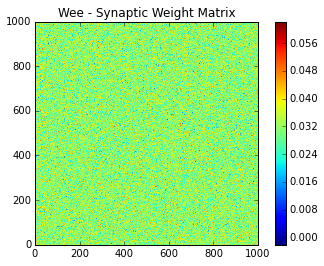

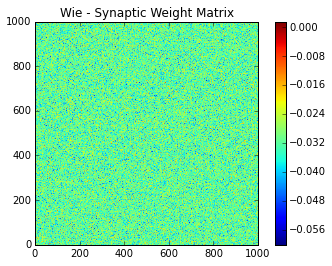

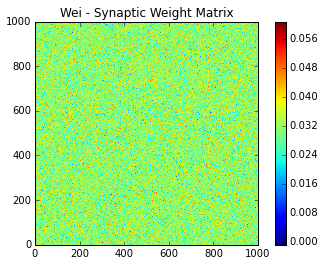

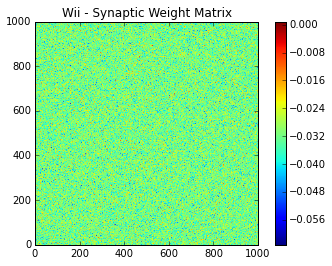

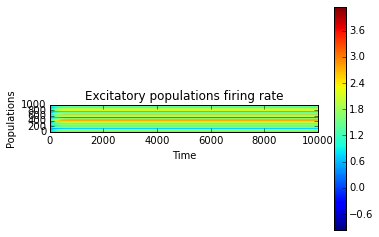

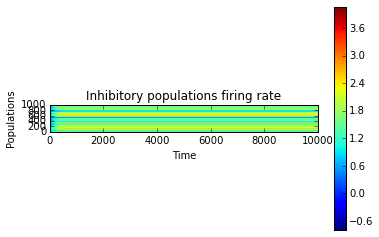

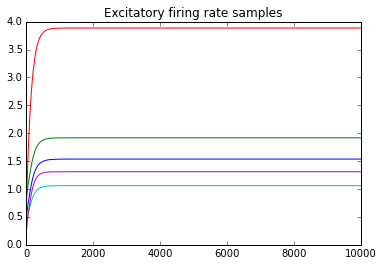

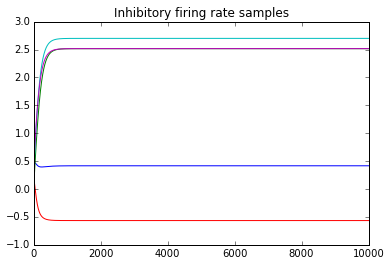

In [6]:
Ne1 = 1000
Ni1 = 1000
esparse1 = 1.0
isparse1 = 1.0
J1 = J1
Wee1, Wei1, Wie1, Wii1 = ConstructEIMatrices(Ne=Ne1,Ni=Ni1,esparse=esparse1,isparse=isparse1,showplots=True)

E1, I1 = RunNetworkSimulation(Wee1, Wei1, Wie1, Wii1, Ne1, Ni1, esparse1, isparse1, J=J1)

## Run simulation 1b
#### Equal number of EI nodes; 50% density

In [1]:
Ne1 = 500
Ni1 = 500
esparse1 = 0.05
isparse1 = 0.002
J1 = J1
Wee1, Wei1, Wie1, Wii1 = ConstructEIMatrices(Ne=Ne1,Ni=Ni1,esparse=esparse1,isparse=isparse1,showplots=True)

E1, I1 = RunNetworkSimulation(Wee1, Wei1, Wie1, Wii1, Ne1, Ni1, esparse1, isparse1, J=5.0, Tmax=50)

NameError: name 'J1' is not defined

# Run simulation 2 - No spontaneous activity
#### Unequal EI ratio - 5:1 EI ratio
#### Fully dense connectivity matrices

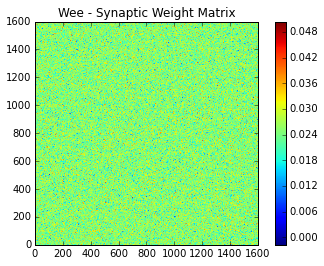

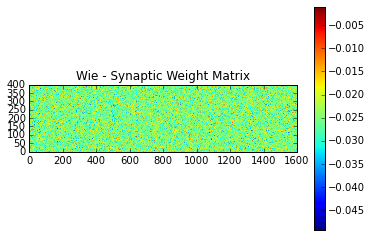

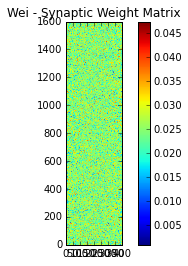

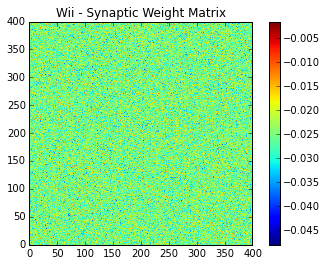

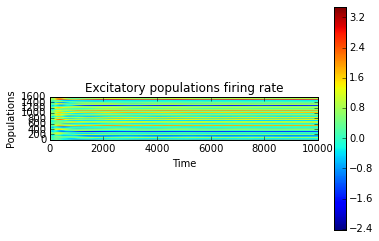

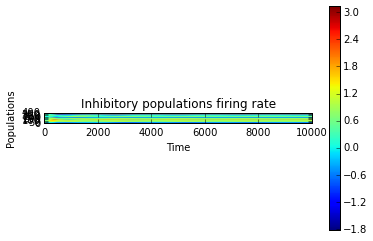

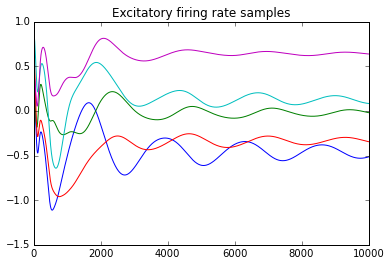

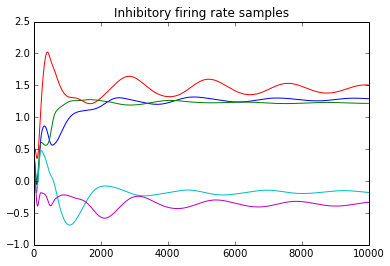

In [188]:
Ne1 = 1600
Ni1 = 400
esparse1 = 1.0
isparse1 = 1.0
J1 = J1
Wee1, Wei1, Wie1, Wii1 = ConstructEIMatrices(Ne=Ne1,Ni=Ni1,esparse=esparse1,isparse=isparse1, showplots=True)

E1, I1 = RunNetworkSimulation(Wee1, Wei1, Wie1, Wii1, Ne1, Ni1, esparse1, isparse1, J=J1)

## Run simulation 3 - No Spontaneous Activity
#### Unequal EI ratio - 5:1 EI ratio
#### E-density = 50%; I-density = 50%

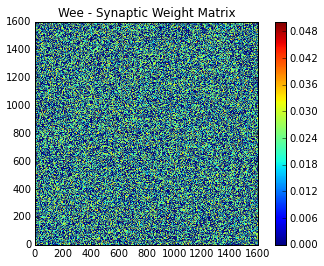

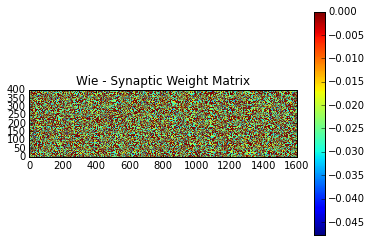

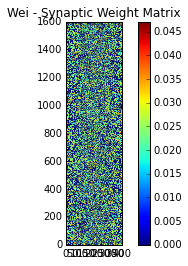

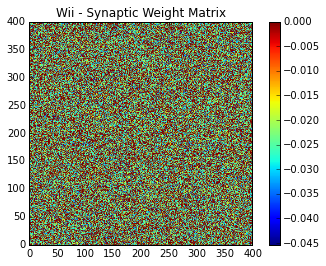

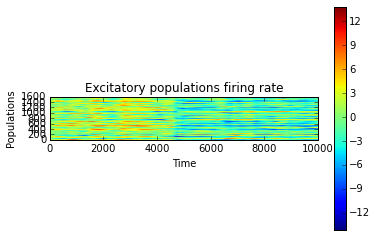

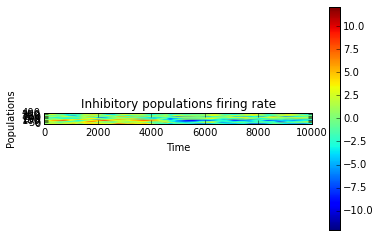

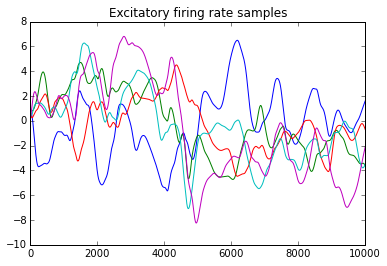

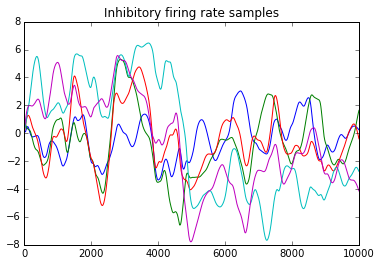

In [189]:
Ne1 = 1600
Ni1 = 400
esparse1 = 0.5
isparse1 = 0.5
J1 = J1
Wee1, Wei1, Wie1, Wii1 = ConstructEIMatrices(Ne=Ne1,Ni=Ni1,esparse=esparse1,isparse=isparse1, showplots=True)

E1, I1 = RunNetworkSimulation(Wee1, Wei1, Wie1, Wii1, Ne1, Ni1, esparse1, isparse1, J=J1)

## Run simulation 4 - No Spontaneous Activity
#### Unequal EI ratio - 5:1 E:I
#### E-density = 10%; I-density = 10%

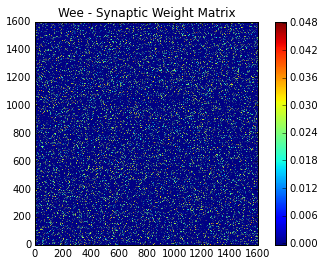

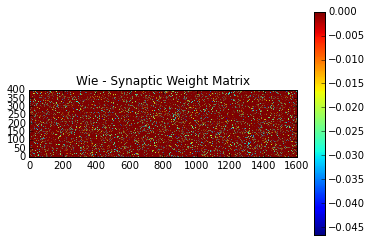

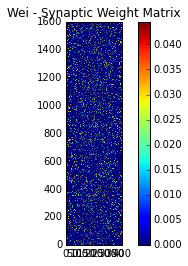

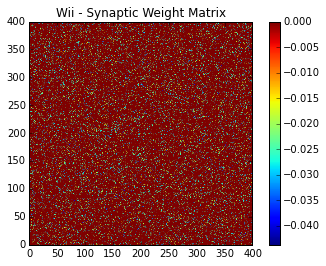

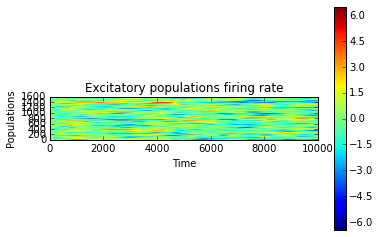

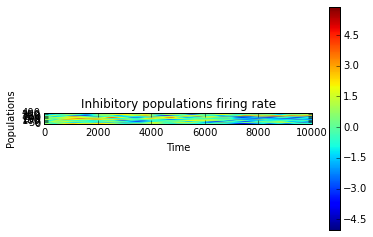

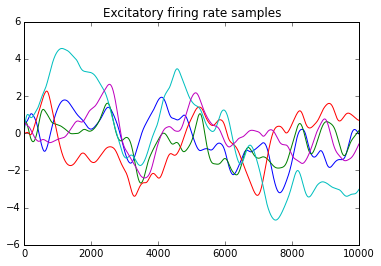

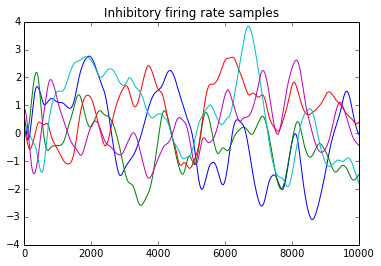

In [190]:
Ne1 = 1600
Ni1 = 400
esparse1 = 0.1
isparse1 = 0.1
J1 = J1
Wee1, Wei1, Wie1, Wii1 = ConstructEIMatrices(Ne=Ne1,Ni=Ni1,esparse=esparse1,isparse=isparse1, showplots=True)

E1, I1 = RunNetworkSimulation(Wee1, Wei1, Wie1, Wii1, Ne1, Ni1, esparse1, isparse1, J=J1)

## Run simulation 5
#### Unequal EI ratio - 5:1 E:I
#### Unequal Density - E-density = 20%; I-density = 40%

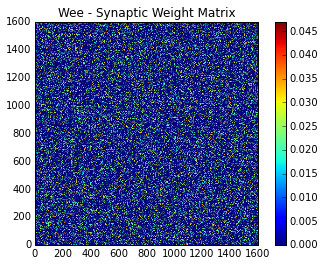

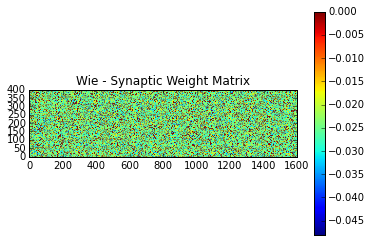

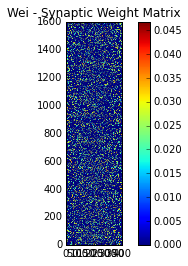

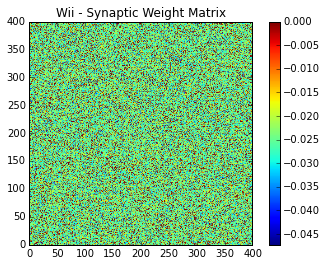

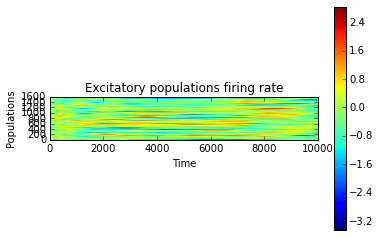

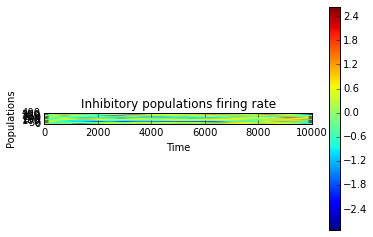

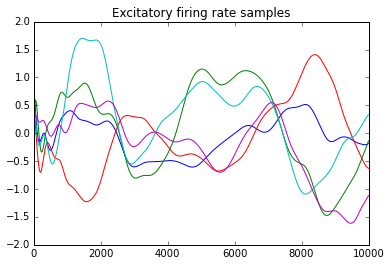

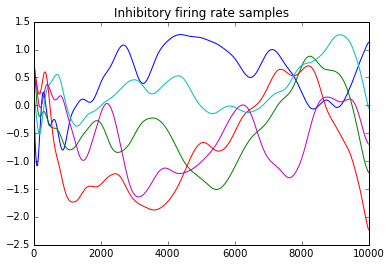

In [191]:
Ne1 = 1600
Ni1 = 400
esparse1 = 0.2
isparse1 = 0.8
J1 = J1
Wee1, Wei1, Wie1, Wii1 = ConstructEIMatrices(Ne=Ne1,Ni=Ni1,esparse=esparse1,isparse=isparse1, showplots=True)

E1, I1 = RunNetworkSimulation(Wee1, Wei1, Wie1, Wii1, Ne1, Ni1, esparse1, isparse1, J=J1)

## Run Simulation 6

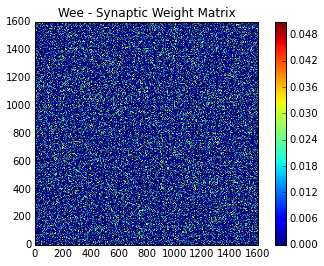

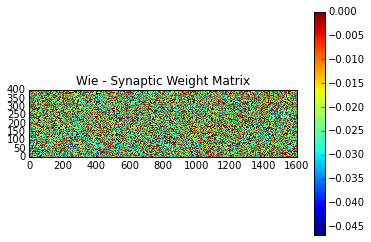

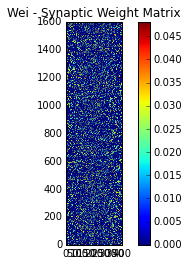

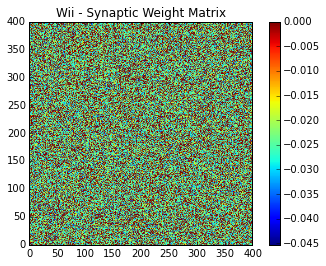

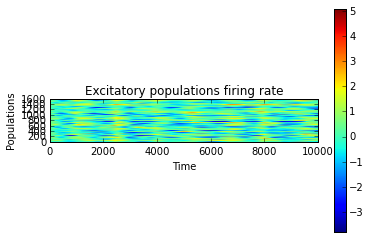

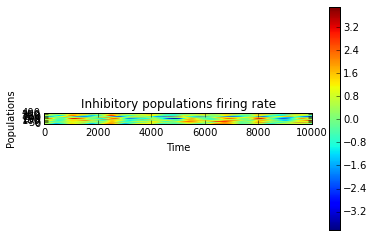

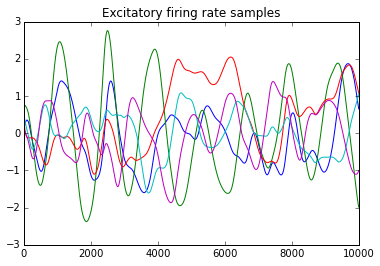

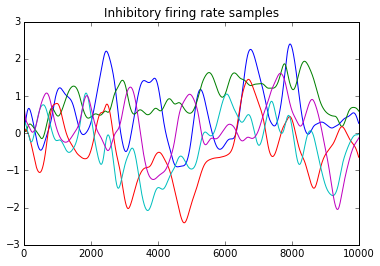

In [192]:
Ne1 = 1600
Ni1 = 400
esparse1 = 0.2
isparse1 = 0.6
J1 = J1
Wee1, Wei1, Wie1, Wii1 = ConstructEIMatrices(Ne=Ne1,Ni=Ni1,esparse=esparse1,isparse=isparse1, showplots=True)

E1, I1 = RunNetworkSimulation(Wee1, Wei1, Wie1, Wii1, Ne1, Ni1, esparse1, isparse1, J=J1)

## Run simulation 7

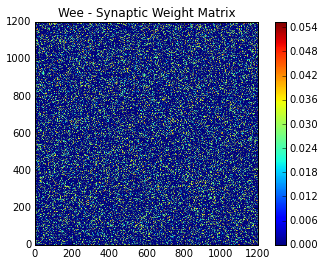

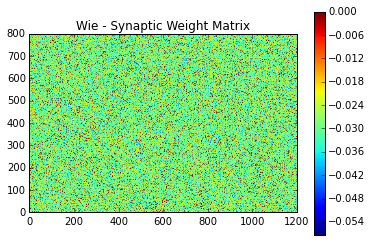

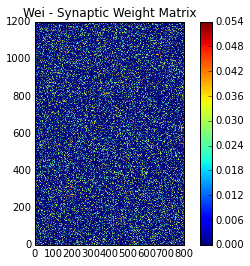

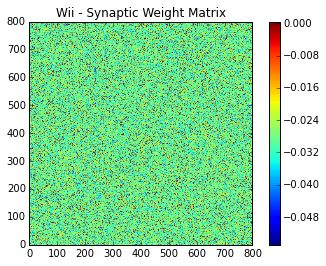

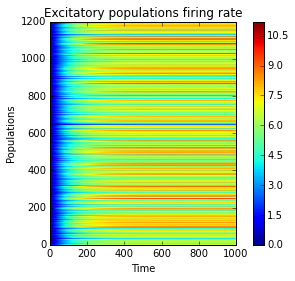

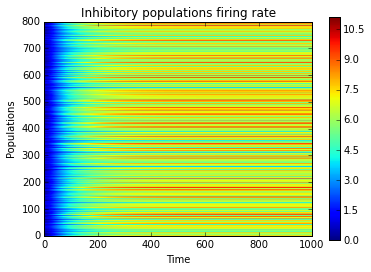

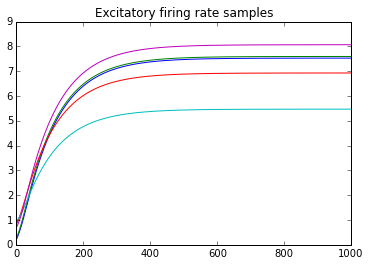

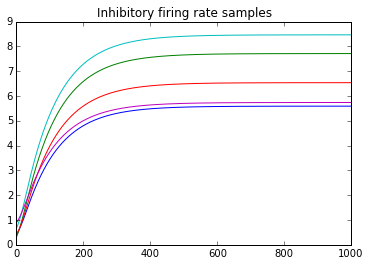

In [216]:
Ne1 = 1200
Ni1 = 800
esparse1 = 0.2
isparse1 = 0.9
Wee1, Wei1, Wie1, Wii1 = ConstructEIMatrices(Ne=Ne1,Ni=Ni1,esparse=esparse1,isparse=isparse1, showplots=True)

E1, I1 = RunNetworkSimulation(Wee1, Wei1, Wie1, Wii1, Ne1, Ni1, esparse1, isparse1, J=3.0, Tmax=10)

## Run simulation 8

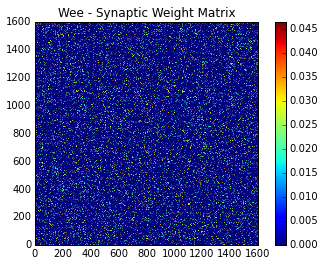

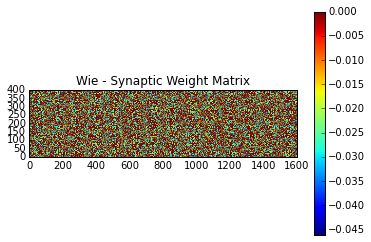

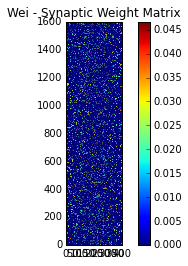

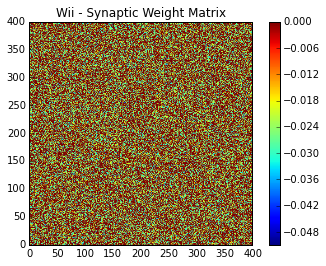

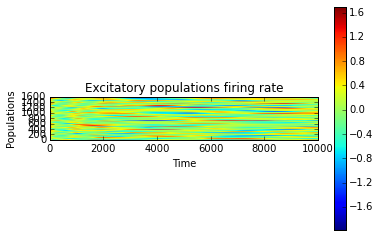

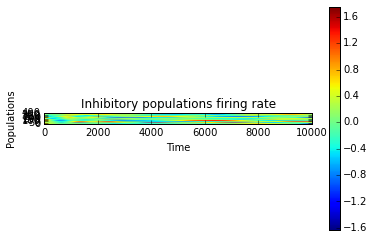

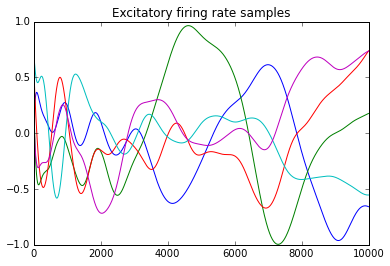

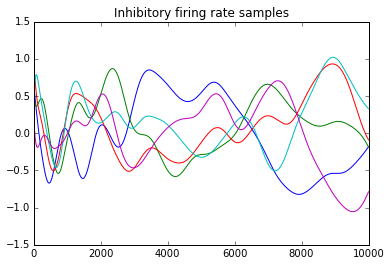

In [220]:
Ne1 = 1600
Ni1 = 400
esparse1 = 0.1
isparse1 = 0.4
Wee1, Wei1, Wie1, Wii1 = ConstructEIMatrices(Ne=Ne1,Ni=Ni1,esparse=esparse1,isparse=isparse1, showplots=True)

E1, I1 = RunNetworkSimulation(Wee1, Wei1, Wie1, Wii1, Ne1, Ni1, esparse1, isparse1, J=J1)

## Run simulation 9

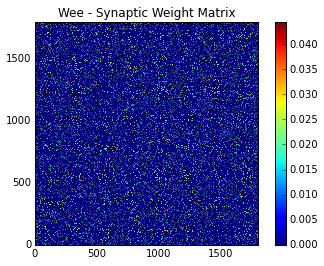

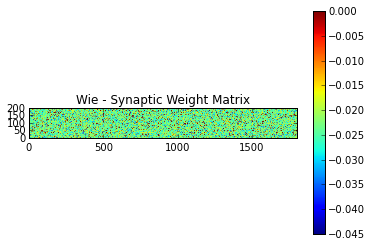

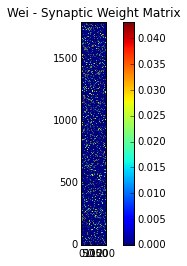

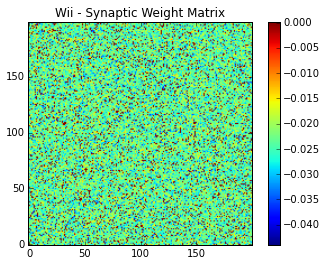

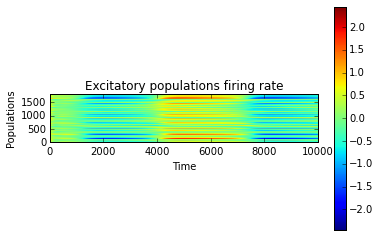

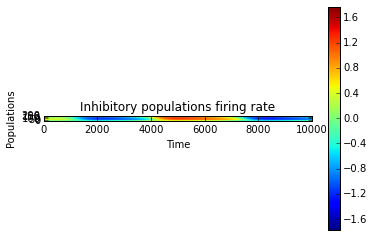

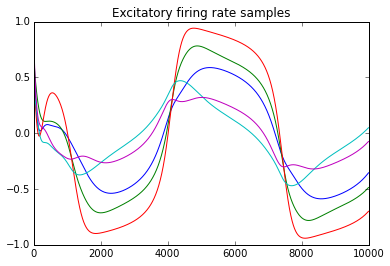

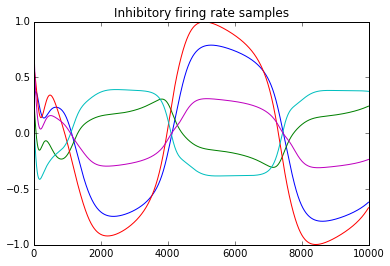

In [224]:
Ne1 = 1800
Ni1 = 200
esparse1 = 0.1
isparse1 = 0.9
Wee1, Wei1, Wie1, Wii1 = ConstructEIMatrices(Ne=Ne1,Ni=Ni1,esparse=esparse1,isparse=isparse1, showplots=True)

E1, I1 = RunNetworkSimulation(Wee1, Wei1, Wie1, Wii1, Ne1, Ni1, esparse1, isparse1, J=J1)

## Run simulation 9b - pretty imbalanced E-I ratio

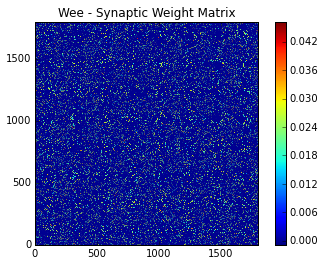

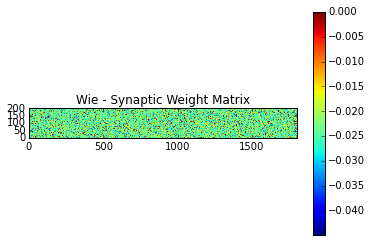

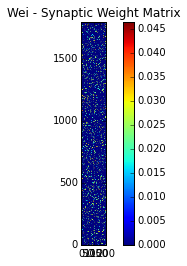

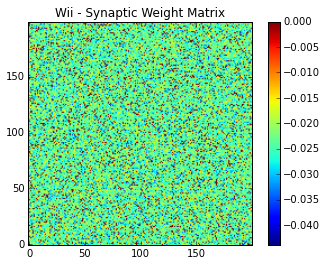

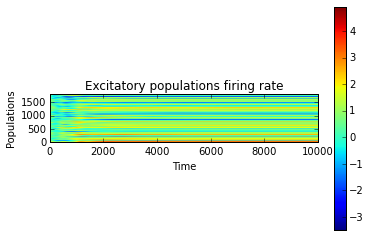

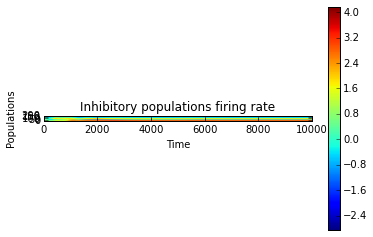

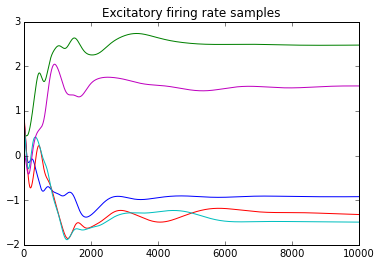

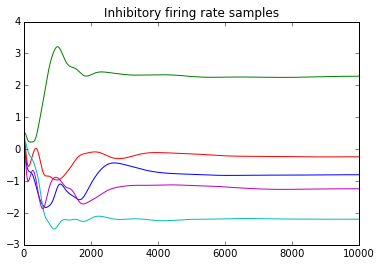

In [225]:
Ne1 = 1800
Ni1 = 200
esparse1 = 0.1
isparse1 = 0.9
J2 = J1+2.0
Wee1, Wei1, Wie1, Wii1 = ConstructEIMatrices(Ne=Ne1,Ni=Ni1,esparse=esparse1,isparse=isparse1, showplots=True)

E1, I1 = RunNetworkSimulation(Wee1, Wei1, Wie1, Wii1, Ne1, Ni1, esparse1, isparse1, J=J2)

## Run simulation 9c1 - highly imbalanced

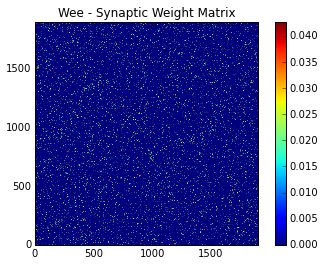

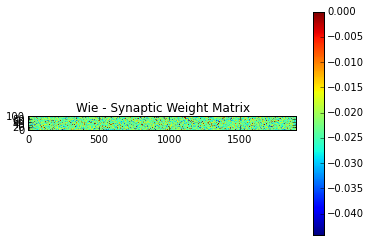

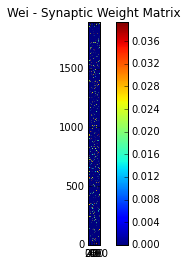

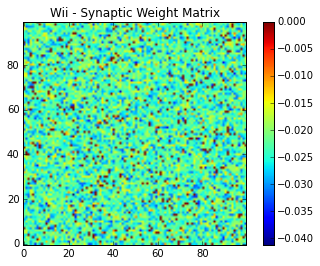

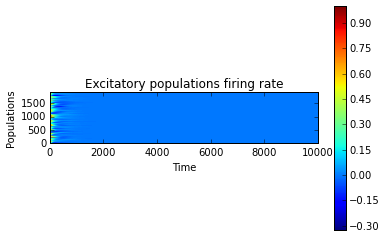

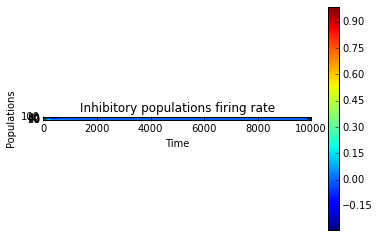

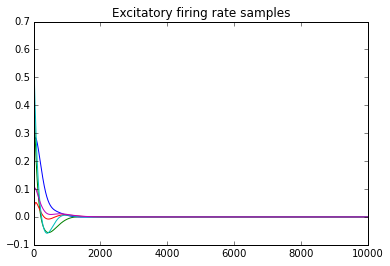

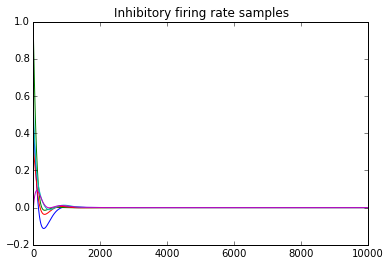

In [229]:
Ne1 = 1900
Ni1 = 100
esparse1 = 0.05
isparse1 = 0.95
Wee1, Wei1, Wie1, Wii1 = ConstructEIMatrices(Ne=Ne1,Ni=Ni1,esparse=esparse1,isparse=isparse1, showplots=True)

E1, I1 = RunNetworkSimulation(Wee1, Wei1, Wie1, Wii1, Ne1, Ni1, esparse1, isparse1, J=J1)

## Run simulation 9c2 - highly imbalanced but increase J

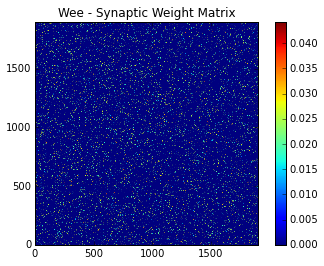

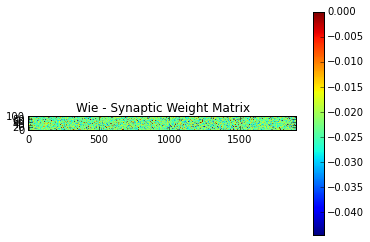

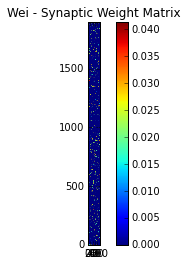

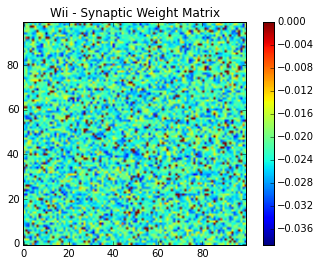

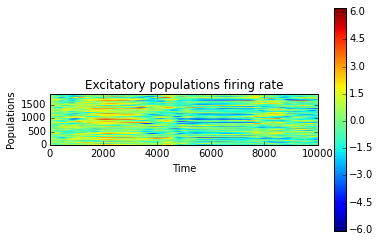

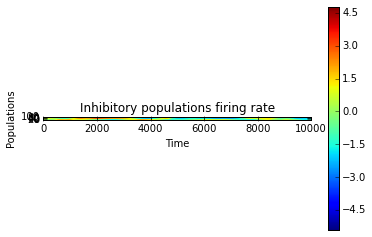

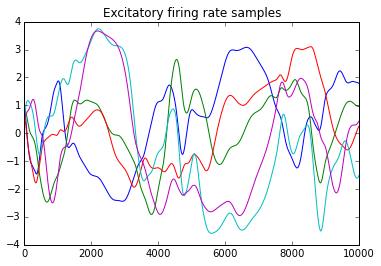

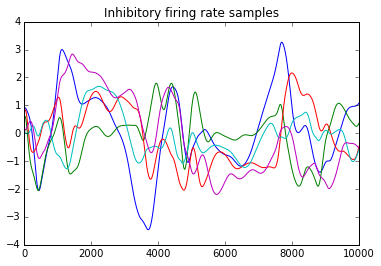

In [226]:
Ne1 = 1900
Ni1 = 100
esparse1 = 0.05
isparse1 = 0.95
J2 = J1+5.0
Wee1, Wei1, Wie1, Wii1 = ConstructEIMatrices(Ne=Ne1,Ni=Ni1,esparse=esparse1,isparse=isparse1, showplots=True)

E1, I1 = RunNetworkSimulation(Wee1, Wei1, Wie1, Wii1, Ne1, Ni1, esparse1, isparse1, J=J2)

## Run simulation 9d1 - crazy imbalance

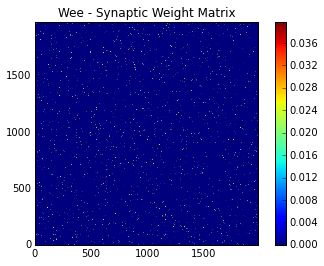

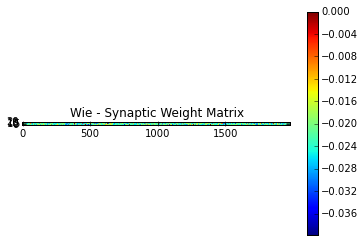

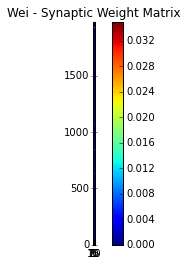

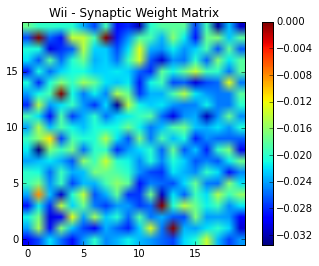

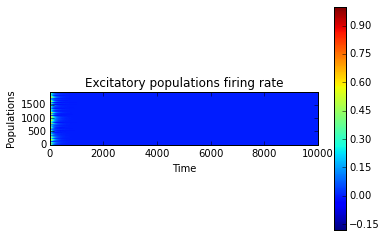

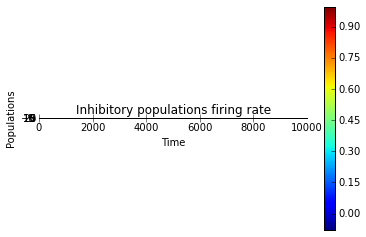

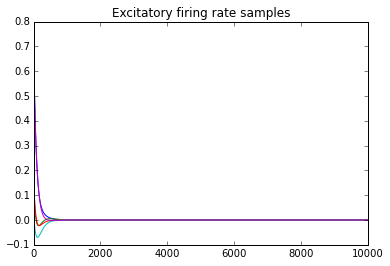

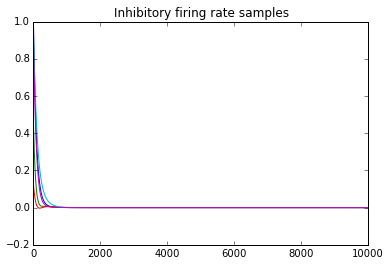

In [230]:
Ne1 = 1980
Ni1 = 20
esparse1 = 0.01
isparse1 = 0.99
Wee1, Wei1, Wie1, Wii1 = ConstructEIMatrices(Ne=Ne1,Ni=Ni1,esparse=esparse1,isparse=isparse1, showplots=True)

E1, I1 = RunNetworkSimulation(Wee1, Wei1, Wie1, Wii1, Ne1, Ni1, esparse1, isparse1, J=J1)

## Run simulation 9d2 - crazy imbalance but increase J

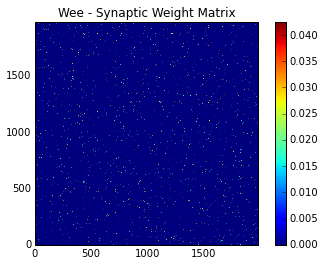

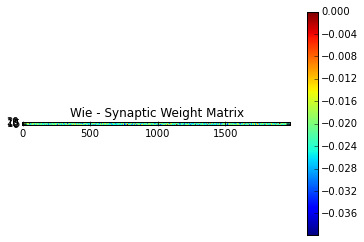

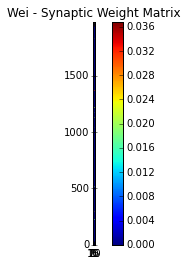

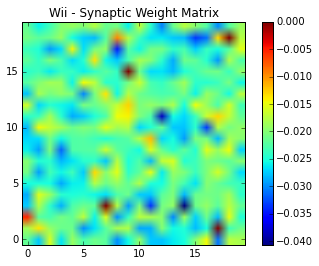

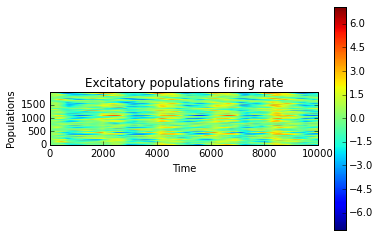

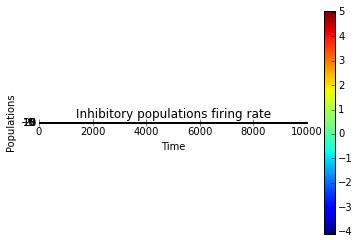

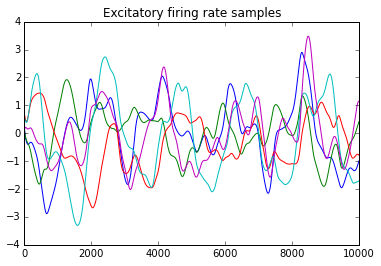

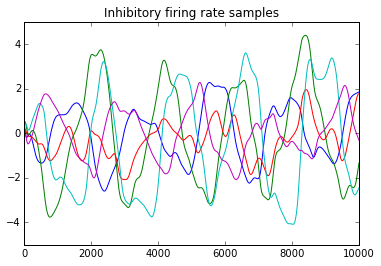

In [231]:
Ne1 = 1980
Ni1 = 20
esparse1 = 0.01
isparse1 = 0.99
J2 = J1+15.0
Wee1, Wei1, Wie1, Wii1 = ConstructEIMatrices(Ne=Ne1,Ni=Ni1,esparse=esparse1,isparse=isparse1, showplots=True)

E1, I1 = RunNetworkSimulation(Wee1, Wei1, Wie1, Wii1, Ne1, Ni1, esparse1, isparse1, J=J2)